In [2]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n-pose.pt')  # load an official model

# Export the model
onnx_file = model.export(format='onnx', dynamic=True)

100%|██████████| 6.51M/6.51M [00:02<00:00, 2.66MB/s]
Ultralytics YOLOv8.0.170  Python-3.11.5 torch-2.0.1+cpu CPU (12th Gen Intel Core(TM) i5-12450H)
YOLOv8n-pose summary (fused): 187 layers, 3289964 parameters, 0 gradients

PyTorch: starting from 'yolov8n-pose.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 56, 8400) (6.5 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: export success  2.9s, saved as 'yolov8n-pose.onnx' (12.6 MB)

Export complete (9.9s)
Results saved to C:\Users\GAUTAM\OneDrive\Desktop\yolov8
Predict:         yolo predict task=pose model=yolov8n-pose.onnx imgsz=640  
Validate:        yolo val task=pose model=yolov8n-pose.onnx imgsz=640 data=/usr/src/app/ultralytics/datasets/coco-pose.yaml  
Visualize:       https://netron.app


============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [3]:
from pathlib import Path

# Define paths
triton_repo_path = Path('tmp') / 'triton_repo'
triton_model_path = triton_repo_path / 'yolo'

# Create directories
(triton_model_path / '1').mkdir(parents=True, exist_ok=True)

In [4]:
from pathlib import Path

# Move ONNX model to Triton Model path
Path(onnx_file).rename(triton_model_path / '1' / 'model.onnx')

# Create config file
(triton_model_path / 'config.pbtxt').touch()

In [4]:
import subprocess
import time
from pathlib import Path

from tritonclient.http import InferenceServerClient
triton_repo_path = Path('tmp') / 'triton_repo'
# Define image https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver
tag = 'nvcr.io/nvidia/tritonserver:23.09-py3'  # 6.4 GB

# Pull the image
subprocess.call(f'docker pull {tag}', shell=True)

# Run the Triton server and capture the container ID
container_id = subprocess.check_output(
    f'docker run -d --rm -v {triton_repo_path}:/models -p 8000:8000 {tag} tritonserver --model-repository=/models',
    shell=True).decode('utf-8').strip()

# Wait for the Triton server to start
triton_client = InferenceServerClient(url='localhost:8000', verbose=False, ssl=False)

CalledProcessError: Command 'docker run -d --rm -v tmp\triton_repo:/models -p 8000:8000 nvcr.io/nvidia/tritonserver:23.09-py3 tritonserver --model-repository=/models' returned non-zero exit status 125.

In [48]:
from ultralytics import YOLO
model = YOLO('yolov8n-pose.onnx') 

In [ ]:
import concurrent.futures
from datetime import datetime
times = []
for n in range(1,20):
    try:
        t1 = datetime.now()
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = executor.map(model, ['3.jpg']*n)
        t2 = datetime.now()
        for i,res in enumerate(results):
            print(i, end = '\r')
    except Exception:
        continue
    times.append(t2-t1)
print(t2-t1)
#results = model('3.jpg')

In [51]:
print(len(times))
inference_time = []
for t in times:
    inference_time.append(t.seconds*1000+t.microseconds/1000)

16


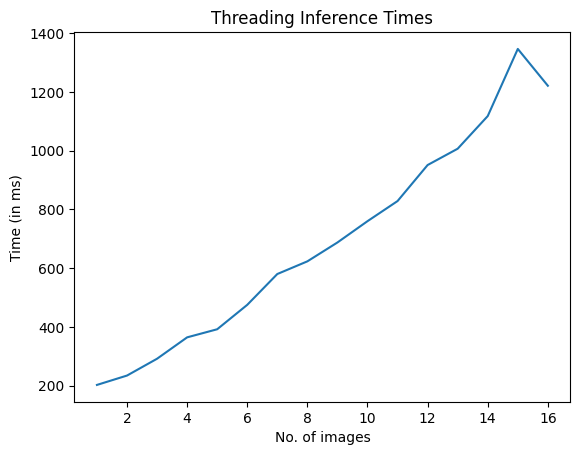

In [52]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(range(1,len(times)+1),np.array(inference_time))
plt.xlabel('No. of images')
plt.ylabel('Time (in ms)')
plt.title('Threading Inference Times')
plt.show()